In [ ]:
# !pip install transformers

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("bigcode/gpt_bigcode-santacoder")
model = AutoModelForCausalLM.from_pretrained("bigcode/gpt_bigcode-santacoder")

c:\Users\62174\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
model

GPTBigCodeForCausalLM(
  (transformer): GPTBigCodeModel(
    (wte): Embedding(49280, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTBigCodeBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTBigCodeSdpaAttention(
          (c_attn): Linear(in_features=2048, out_features=2304, bias=True)
          (c_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTBigCodeMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_features=8192, out_features=2048, bias=True)
          (act): PytorchGELUTanh()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2048,), ep

In [ ]:
import torch
import torch.nn as nn
import copy
import gc
from time import time
import matplotlib.pyplot as plt

In [7]:
torch.cuda.is_available()

True

Мы не будем обучать модель, поэтому можно сделать так:

In [8]:
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
def test_model(model, test_strings):
    """ 
    Заставляет модель генерировать код по тестовым строкам

    model: модель
    test_strings: тестовые строки
    
    returns: среднее по тестовым строкам время генерации
    """
    avg_time = 0
    for test_string in test_strings:
        print("Test string: " + f"\"{test_string}\"")
        start_time = time()
        beam_output_seq = model.generate(
            **tokenizer(test_string, return_tensors="pt").to("cuda"),
            max_length=100,
            num_return_sequences=5,
            num_beams=5,
        )
        end_time = time()
        avg_time += end_time - start_time
        for i, beam_output in enumerate(beam_output_seq):
            print(
                "{}: {}".format(
                    i, tokenizer.decode(beam_output, skip_special_tokens=True)
                )
            )
        print("#" * 100)
    avg_time /= len(test_strings)
    return avg_time

In [10]:
class SVDLayer(nn.Module):
    def __init__(self, A, bias, rank):
        super().__init__()
        U, S, Vt = torch.linalg.svd(A, full_matrices=False)
        r = min(
            (~torch.isclose(S, torch.zeros_like(S), atol=1e-5)).sum().ceil().int(), rank
        )
        self.U_S = nn.Parameter(U[:, :r] @ torch.diag(S[:r]))
        self.Vt = nn.Parameter(Vt[:r, :])
        self.bias = nn.Parameter(bias)

    def forward(self, x):
        return nn.functional.linear(nn.functional.linear(x, self.Vt), self.U_S, self.bias)

In [ ]:
def get_model_size(model):
    """ 
    Вычисляет размер модели в битах
    
    model: модель
    
    returns: размер модели в битах
    """
    size_model = 0
    for param in model.parameters():
        if param.data.is_floating_point():
            size_model += param.numel() * torch.finfo(param.data.dtype).bits
        else:
            size_model += param.numel() * torch.iinfo(param.data.dtype).bits
    return size_model

In [12]:
def count_parameters(model):
    """
    Вычисляет число параметров в модели

    model: модель

    returns: число параметров
    """
    return sum(p.numel() for p in model.parameters())

In [ ]:
def replace_layers(model, rank, flag=False):
    """ 
    Заменяет линейные слои в MLP блоке на сжатые c помощью SVD слои 

    model: модель
    rank: ранг сжатия в SVD
    flag: Bool, нужен при рекурсивном вызове чтобы понять, что мы в MLP блоке

    """
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            if 'mlp' in name:
                flag = True
            replace_layers(module, rank, flag)

        if flag and isinstance(module, nn.Linear):
            W, bias = module.weight, module.bias
            compressed_module = SVDLayer(W, bias, rank)
            compressed_module.U_S.requires_grad_(False)
            compressed_module.Vt.requires_grad_(False)
            compressed_module.bias.requires_grad_(False)
            setattr(model, name, compressed_module)

In [ ]:
def compress_and_evaluate_model(model, rank, test_strings):
    """ 
    Сжимает линейные слои в MLP в модели

    model: модель
    rank: ранг сжатия в SVD
    test_strings: тестовые строки

    returns: tuple из size, gen_time, n_params, где
    
    size: размер модели
    gen_time: среднее время генерации
    n_params: число параметров в модели
    
    """
    compressed_model = copy.deepcopy(model).to("cuda")
    replace_layers(compressed_model, rank)
    size, gen_time, n_params = (
        get_model_size(compressed_model),
        test_model(compressed_model, test_strings),
        count_parameters(compressed_model),
    )
    del compressed_model
    gc.collect()
    torch.cuda.empty_cache()
    return size, gen_time, n_params


Напишем следующие тестовые строки:

In [15]:
test_strings = [
    "def replace_nans_w_zeros(df):",
    "def find_index_of_max(arr):",
    "class Complex():",
    "def solve_quad(a, b, c):",
    "def is_palindrome(s):"
]

Ожидается, что модель будет выдавать классические решения-oneliner'ы. Как только модель начнет выдавать что-то нелогичное или бессвязное, мы сразу поймём факт деградации модели при сильном сжатии.

Протестируем несжатую модель: посмотрим, какой код она генерирует, а также вычислим её размер и количество параметров

In [16]:
model_copy = copy.deepcopy(model).to('cuda')
uncompressed_size, uncompressed_times, uncompressed_params = (
    get_model_size(model_copy),
    test_model(model_copy, test_strings),
    count_parameters(model_copy)
)

del model_copy
gc.collect()
torch.cuda.empty_cache()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


c:\Users\62174\anaconda3\Lib\site-packages\transformers\models\gpt_bigcode\modeling_gpt_bigcode.py:453: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  sdpa_result = torch.nn.functional.scaled_dot_product_attention(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
            df[col] = df[col].replace(np.nan, 0)
    return df


def replace_nans_w_mean(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
            df[col] = df[col].replace(np.
1: def replace_nans_w_zeros(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
            df[col] = df[col].replace(np.nan, 0)
    return df


def replace_nans_with_median(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
            df[col] = df[col].replace(np.
2: def replace_nans_w_zeros(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
            df[col] = df[col].replace(np.nan, 0)
    return df


def replace_nans_with_mean(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
            df[col] = df[col].replace(np.
3: def replace_nans_w_zeros(df):
    for col in df.columns:
        if np.isnan(df[col]).any():
           

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):
    max_value = arr[0]
    max_index = 0
    for i in range(1, len(arr)):
        if arr[i] > max_value:
            max_value = arr[i]
            max_index = i
    return max_index


def find_index_of_min(arr):
    min_value = arr[0]
    min_index = 0
   
1: def find_index_of_max(arr):
    max_index = 0
    max_value = arr[0]
    for i in range(1, len(arr)):
        if arr[i] > max_value:
            max_value = arr[i]
            max_index = i
    return max_index


def find_index_of_min(arr):
    min_index = 0
    min_value = arr[0]
   
2: def find_index_of_max(arr):
    max_index = 0
    max_value = arr[0]
    for i in range(1, len(arr)):
        if arr[i] > max_value:
            max_index = i
            max_value = arr[i]
    return max_index


def find_index_of_min(arr):
    min_index = 0
    min_value = arr[0]
   
3: def find_index_of_max(arr):
    max_value = arr[0]
    max_index = 0
    for i in range(1, len(arr)):
        if arr[i] > max_valu

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex():
    def __init__(self, real, imag):
        self.real = real
        self.imag = imag

    def __add__(self, other):
        return Complex(self.real + other.real, self.imag + other.imag)

    def __sub__(self, other):
        return Complex(self.real - other.real, self.imag - other.imag)

    def __mul__(self, other):
        return Complex(self.real
1: class Complex():
    def __init__(self, real, imaginary):
        self.real = real
        self.imaginary = imaginary

    def __add__(self, other):
        return Complex(self.real + other.real, self.imaginary + other.imaginary)

    def __sub__(self, other):
        return Complex(self.real - other.real, self.imaginary - other.imaginary)

    def __mul__(self, other):
2: class Complex():
    def __init__(self, realpart, imagpart):
        self.realpart = realpart
        self.imagpart = imagpart

    def __add__(self, other):
        return Complex(self.realpart + other.realpart, self.imagpart + other.imagpart)

 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_cubic(a, b, c, d):
    return (-b - math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_quartic(a, b, c, d, e):
   
1: def solve_quad(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_cubic(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_quartic(a, b, c):
    return (-b + math.
2: def solve_quad(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_cubic(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_quartic(a, b, c, d):
    return (-b +
3: def solve_quad(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_cubic(a, b, c):
    return (-b - math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_quartic(a, b, c):
    return (-b + math.
4: def solve_quad(a, b, c):
    return (-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


def solve_cubic(a, b, c):

Пусть $W \in \mathbb{R}^{m\times n}$, $x \in\mathbb{R}^{n}$. Запишем сингулярное разложение матрицы $W = U\Sigma V^\top$, после чего запишем сжатую матрицу $W_r = \overbrace{U_r \Sigma_r}^{\in \mathbb{R}^{m\times r}} \overbrace{V_r^\top}^{\in\mathbb{R}^{r\times n}}$. Мы будем хранить в памяти две матрицы: $(U_r \Sigma_r)$ и $V_r^\top$. Значит, в памяти нужно хранить $(m+n)r$ чисел. Для хранения исходной матрицы требовалось $mn$ чисел. Мы хотим получить выигрыш в памяти, поэтому имеет смысл выбирать ранг $r$ так, чтобы выполнялось неравенство
$$(m+n)r \leqslant mn \Longleftrightarrow r \leqslant \frac{mn}{m+n}$$
В нашем случае, веса линейных слоев берутся из MLP блока, $m=2048, n=8192$ (с точностью до перестановки), поэтому имеет смысл брать ранг сжатия $r \leqslant \dfrac{2048\cdot8192}{2048+8192} \approx 1638$.

In [17]:
ranks, sizes, times, arr_n_params = (
    [1000, 1250, 1375, 1400, 1425, 1500],
    [],
    [],
    []
)

for rank in ranks:
    print(f"Rank = {rank}")
    size, gen_time, n_params = compress_and_evaluate_model(model, rank, test_strings)
    sizes.append(size), times.append(gen_time), arr_n_params.append(n_params)

Rank = 1000


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):nannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannan
1: def replace_nans_w_zeros(df):nannannannannan
nannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannan
2: def replace_nans_w_zeros(df):nannannannan
nannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannan
3: def replace_nans_w_zeros(df):nannannannannannan
nannannannannannannannannannannannannannannannannanna

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):log.2.1111 
 
 
       .                                                                  
1: def find_index_of_max(arr):log.2.1111 
 
 
        .                                                                 
2: def find_index_of_max(arr):log.2.1111 
 
 
         .                                                                
3: def find_index_of_max(arr):log.2.1111 
 
 
       .                                                             .    
4: def find_index_of_max(arr):log.2.1111 
 
 
       .                                                     .            
####################################################################################################
Test string: "class Complex():"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex(): Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex
1: class Complex(): Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex Complex 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):quadququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququ
1: def solve_quad(a, b, c):quadquadquadququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququ
2: def solve_quad(a, b, c):quadquadquququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququ
3: def solve_quad(a, b, c):quadquququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququque
4: def solve_quad(a, b, c):quadquququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququququ

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):
   ._w_zeros(w_zeros)df)dfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdf
1: def replace_nans_w_zeros(df):
   ._w_zeros(w_zeros)df)wdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdfdf
2: def replace_nans_w_zeros(df):
   ._w_zeros(w_zeros)w.w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros w zeros
3: def replace_nans_w_zeros(df):
   ._w_zeros(w_zeros)w)w)w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w w
4: def replace_

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):max_max,maxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmax
1: def find_index_of_max(arr):max_max-maxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmax
2: def find_index_of_max(arr):max_max,max,maxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmax
3: def find_index_of_max(arr):max_max-max-maxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmaxmax

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex():

    def __init__(self, self):

   ):
Log.Log.Log(Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog
1: class Complex():

    def __init__(self, self):

   ):
Log.Log.Log(Log.Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog
2: class Complex():

    def __init__(self, self):

   ):
Log.Log.Log(Log(Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog
3: class Complex():

    def __init__(self, self):

   ):
Log.Log.Log(Log.Log.Log.Log.LogLog

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):
Log.Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog
1: def solve_quad(a, b, c):
Log.Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLog(LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog
2: def solve_quad(a, b, c):
Log.Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLogLog(LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog
3: def solve_quad(a, b, c):
Log.Log.Log.LogLogLogLogLogLogLogLogLogLogLogLogLogLogLog(LogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLogLog

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):
   _df = df.replace(np.nan, 0)
df = df.replace(np.inf, 0)
df = df.replace(-np.inf, 0)
df = df.replace(np.nan, np.inf)
df = df.replace(np.inf, -np.inf)
df = df.replace(-np.inf, -np.inf
1: def replace_nans_w_zeros(df):
   _df = df.replace(np.nan, 0)
df = df.replace(np.inf, 0)
df = df.replace(-np.inf, 0)
df = df = df.replace(np.nan, np.inf)
df = df.replace(np.inf, -np.inf)
df = df.replace(-np.inf, -np
2: def replace_nans_w_zeros(df):
   _df = df.replace(np.nan, 0)
df = df.replace(np.inf, -np.inf)
df = df.replace(-np.inf, np.inf)
df = df.replace(np.nan, np.nan)
df = df.replace(np.inf, np.inf)
df = df.replace(np.inf, np.
3: def replace_nans_w_zeros(df):
   _df = df.replace(np.nan, 0)
df = df.replace(np.inf, -np.inf)
df = df.replace(-np.inf, np.inf)
df = df.replace(np.nan, np.nan)
df = df.replace(np.inf, np.inf)
df = df.replace(-np.inf, -np
4: def replace_nans_w_zeros(df):
   _df = df.replace(np.nan, 0)
df = df.replace(np.inf, -np.inf)
df = df.replace(-np.inf

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):

def find_index_of_min(arr):
def find_index_of_max(arr):
def find_index_of_min(arr):
def find_index_of_max(arr)
def find_index_of_min(arr)
def find_index_of_max(arr)
def find_index_of_min(arr)
def find_
1: def find_index_of_max(arr):

def find_index_of_min(arr):
def find_index_of_max(arr):
def find_index_of_min(arr)
def find_index_of_max(arr)
def find_index_of_min(arr)
def find_index_of_max(arr)
def find_index_of_min(arr)
def find_
2: def find_index_of_max(arr):

def find_index_of_min(arr):
def find_index_of_max(arr):
def find_index_of_min(arr):
def find_index_of_max(arr):
def find_index_of_min(arr)
def find_index_of_max(arr)
def find_index_of_min(arr)
def find_
3: def find_index_of_max(arr):

def find_index_of_min(arr):
def find_index_of_max(arr):
def find_index_of_min(arr):
def find_index_of_max(arr)
def find_index_of_min(arr)
def find_index_of_max(arr)
def find_index_of_max(arr)
def find_
4: def find_index_of_max(arr):

def find_index_of_min(arr):
def 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex():
   
	def __init__(self, x, y, z):
		self.x = x
	self.y = y
	self.z = z

	def __add__(self, other):
		return Complex(self.x + other.x, self.y + other.y, self.z + other.z)

	def __sub__(self, other):
	 return Complex(self.x - other.x, self.
1: class Complex():
   
	def __init__(self, x, y, z):
		self.x = x
	self.y = y
	self.z = z

	def __add__(self, other):
		return Complex(self.x + other.x, self.y + other.y, other.z)

	def __sub__(self, other):
	 return Complex(self.x - other.x, self.y - other.
2: class Complex():
   
	def __init__(self, x, y, z):
		self.x = x
	self.y = y
	self.z = z

	def __add__(self, other):
		return Complex(self.x+other.x, self.y+other.y, self.z+other.z)

	def __sub__(self, other):
	 return Complex(self.x-other.x, self.
3: class Complex():
   
	def __init__(self, x, y, z):
		self.x = x
	self.y = y
	self.z = z

	def __add__(self, other):
		return Complex(self.x + other.x, self.y + other.y, self.z + other.z)

	def __radd__(self, other):
	 return Co

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u
1: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
2: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
3: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 1, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
4: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
####################################################################################################
Test string: "def is_palindrome(s):"
0: def is_palindrome(s):
	return s == s[::-1]


def is_palindrome(s):
def is_palindrome(s):
def is_palindrome(s):
def is_palin

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):
	df.replace(np.nan, 0, inplace=True)
	return df


def replace_nans_w_ones(df):
	df.replace(np.nan, 1, inplace=True)
	return df


def replace_nans_w_nan(df):
	df.replace(np.nan, np.nan, inplace=True)

1: def replace_nans_w_zeros(df):
	df.replace(np.nan, 0, inplace=True)
	return df


def replace_nans_w_ones(df):
	df.replace(np.nan, 1, inplace=True)
	return df


def replace_nans_w_all(df):
	df.replace(np.nan, np.nan, inplace=True)

2: def replace_nans_w_zeros(df):
	df.replace(np.nan, 0, inplace=True)
	return df


def replace_nans_w_ones(df):
	df.replace(np.nan, 1, inplace=True)
	return df


def replace_nans_w_nan(df):
	df.replace(np.nan, np.nan, inplace=True)
   
3: def replace_nans_w_zeros(df):
	df.replace(np.nan, 0, inplace=True)
	return df


def replace_nans_w_ones(df):
	df.replace(np.nan, 1, inplace=True)
	return df


def replace_nans_w_all(df):
	df.replace(np.nan, 1, inplace=True)
df
4: def replace_nans_w_zeros(df):
	df.replace(np.nan, 0, inplace=True

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_first(arr):
	return arr.index(arr[0])

def find_index_of_last(arr):
 return arr.index(arr[-1])

def find_
1: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_max_min(arr):
	return find_index_of_max(arr)

def find_index_of_min_max(arr):
	return find_index_of_
2: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_max_and_min(arr):
	return find_index_of_max(arr), find_index_of_min(arr)

def find_index_of_max_and
3: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_max_min(arr):
	return find_index_of_max(arr) + find_index_of_min(arr)

def find_index_of_max_min_
4: def find_index_of_max(arr):
	return arr.inde

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex():
   
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __add__(self, other):
		return Complex(self.x + other.x, self.y + other.y)

	def __sub__(self, other):
	 return Complex(self.x - other.x, self.y - other.y)

	def __mul__(self, other
1: class Complex():
   
	def __init__(self, x, y, z):
		self.x = x
		self.y = y
		self.z = z

	def __add__(self, other):
		return Complex(self.x + other.x, self.y + other.y, self.z + other.z)

	def __sub__(self, other):
	 return Complex(self.x - other.x,
2: class Complex():
   
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __add__(self, other):
		return Complex(self.x+other.x, self.y+other.y)

	def __sub__(self, other):
	 return Complex(self.x-other.x, self.y-other.y)

	def __mul__(self, other
3: class Complex():
   
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __add__(self, other):
		return Complex(self.x + other.x, self.y + other.y)

	def __radd__(self, other):
	 return Complex(other.x + self.x, o

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u
1: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3,
2: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
3: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 
4: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
####################################################################################################
Test string: "def is_palindrome(s):"
0: def is_palindrome(s):
    return s == s[::-1]


def is_palindrome(s): return s == s[::-1]
def is_palindrome(s): return s ==

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):
   
	df = df.replace(np.nan, 0)
	df = df.replace(np.inf, 0)
	df = df.replace(-np.inf, 0)
	df = df.replace(np.nan, np.nan)
	df = df.replace(np.inf, np.inf)
	df = df.replace(-np.inf
1: def replace_nans_w_zeros(df):
   
	df = df.replace(np.nan, 0)
	df = df.replace(np.inf, 0)
	df = df.replace(-np.inf, 0)
	df = df.replace(np.nan, np.inf)
	df = df.replace(np.inf, -np.inf)
df = df.replace(-np.inf
2: def replace_nans_w_zeros(df):
   
	df = df.replace(np.nan, 0)
	df = df.replace(np.inf, 0)
	df = df.replace(-np.inf, 0)
	df = df.replace(np.nan, 0)
	df = df.replace(np.inf, 0)
	df = df.replace(-np.inf, 
3: def replace_nans_w_zeros(df):
   
	df = df.replace(np.nan, 0)
	df = df.replace(np.inf, 0)
	df = df.replace(-np.inf, 0)
	df = df.replace(np.inf, np.inf)
	df = df.replace(-np.inf, -np.inf)
df = df.replace(np.inf
4: def replace_nans_w_zeros(df):
   
	df = df.replace(np.nan, 0)
	df = df.replace(np.inf, 0)
	df = df.replace(-np.inf, 0)
	df = df.replace(np.inf, np.inf)
	

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_mean(arr):
	return arr.index(mean(arr))


def find_index_of_median(arr):
	return arr.index(median(arr))

def
1: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_mean(arr):
	return arr.index(np.mean(arr))


def find_index_of_median(arr):
	return arr.index(np.median(arr
2: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_min_and_max(arr):
	return find_index_of_min(arr), find_index_of_max(arr)


def find_index_of_min_
3: def find_index_of_max(arr):
	return arr.index(max(arr))


def find_index_of_min(arr):
	return arr.index(min(arr))


def find_index_of_max_min(arr):
	return find_index_of_max(arr) + find_index_of_min(arr)


def find_index_of_max_min
4: def find_index_of_max(arr):
	return 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex():
   
    def __init__(self, x, y):
        self.x = x
         self.y = y
    
def __str__(self):
   return "(%s, %s)" % (self.x, self.y)
def __add__(self, other):
    return Complex(self.x + other.x, self.y + other.y)
def __sub__(self, other): return Complex(self.x
1: class Complex():
   
    def __init__(self, x, y):
        self.x = x
         self.y = y
    
def __str__(self):
   return "(%s, %s)" % (self.x, self.y)
def __add__(self, other):
    return Complex(self.x+other.x, self.y+other.y)
def __sub__(self, other): return Complex(self.x
2: class Complex():
   
    def __init__(self, x, y):
        self.x = x
         self.y = y
    
def __str__(self):
   return "(%s, %s)" % (self.x, self.y)
def __add__(self, other):
    return Complex(self.x + other.x, self.y + other.y)
def __mul__(self, other): return Complex(self.x
3: class Complex():
   
    def __init__(self, x, y):
        self.x = x
         self.y = y
    
def __str__(self):
   return "%s, %s" % (self.x,

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
1: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3,
2: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
3: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1
4: def solve_quad(a, b, c):
   , d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4
####################################################################################################
Test string: "def is_palindrome(s):"
0: def is_palindrome(s):
   
	return s == s[::-1]


def is_palindrome(s):
	return s == s[::-1]
def is_palindrome(s):
	return s == s[::-1]
def is_pa

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Test string: "def replace_nans_w_zeros(df):"


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def replace_nans_w_zeros(df):
    df.replace(np.nan, 0, inplace=True)
    return df

def replace_nans_w_ones(df):
    df.replace(np.nan, 1, inplace=True)
    return df

def replace_zeros_w_nans(df):
    df.replace(0, np.nan, inplace=True)
    return df
def replace_zeros_w
1: def replace_nans_w_zeros(df):
    df.replace(np.nan, 0, inplace=True)
    return df

def replace_nans_w_ones(df):
    df.replace(np.nan, 1, inplace=True)
    return df

def replace_zeros_w_nans(df):
    df.replace(0, np.nan, inplace=True)
    return df
def replace_ones_w
2: def replace_nans_w_zeros(df):
    df.replace(np.nan, 0, inplace=True)
    return df

def replace_nans_w_ones(df):
    df.replace(np.nan, 1, inplace=True)
    return df

def replace_nans_w_random(df):
    df.replace(np.nan, np.random.random(), inplace=True)
    return df

def
3: def replace_nans_w_zeros(df):
    df.replace(np.nan, 0, inplace=True)
    return df

def replace_nans_w_ones(df):
    df.replace(np.nan, 1, inplace=True)
    return df

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def find_index_of_max(arr):
    return arr.index(max(arr))

def find_index_of_min(arr):
    return arr.index(min(arr))

def find_index_of_mean(arr):
    return arr.index(np.mean(arr))

def find_index_of_median(arr):
    return arr.index(np.median(arr))
def find_index_
1: def find_index_of_max(arr):
    return arr.index(max(arr))

def find_index_of_min(arr):
    return arr.index(min(arr))

def find_index_of_mean(arr):
    return arr.index(np.mean(arr))

def find_index_of_median(arr):
    return arr.index(np.median(arr))

def find_index
2: def find_index_of_max(arr):
    arr.sort()
    return arr.index(max(arr))

def find_index_of_min(arr):
    arr.sort()
    return arr.index(min(arr))

def find_index_of_mean(arr):
    arr.sort()
    return arr.index(sum(arr)/len(arr))

def find_index_of_median(arr):
   
3: def find_index_of_max(arr):
    return arr.index(max(arr))

def find_index_of_min(arr):
    return arr.index(min(arr))

def find_index_of_mean(arr):
    return arr.index(sum(arr)/l

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: class Complex():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Complex(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return Complex(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        return Complex(self.x
1: class Complex():
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def __add__(self, other):
        return Complex(self.a + other.a, self.b + other.b)

    def __sub__(self, other):
        return Complex(self.a - other.a, self.b - other.b)

    def __mul__(self, other):
        return Complex(self.a
2: class Complex():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Complex(self.x + other.x, self.y + other.y)

    def __radd__(self, other):
        return Complex(other.x + self.x, other.y + self.y)

    def __sub__(self, other):
        return Complex(self.
3: class Comp

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


0: def solve_quad(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a)

def solve_cubic(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a)

def solve_quartic(a, b, c):
    return (-b + math.sqrt(
1: def solve_quad(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c))/(2*a)

def solve_cubic(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c))/(2*a)

def solve_quartic(a, b, c):
    return (-b + math.sqrt(b**
2: def solve_quad(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a)

def solve_cubic(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a*c)

def solve_quartic(a, b, c):
    return (-b + math.
3: def solve_quad(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a)

def solve_cubic(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c)) / (2*a)

def solve_quartic(a, b, c, d):
    return (-b + math.
4: def solve_quad(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c))/(2*a)

def solve_cubic(a, b, c):
    return (-b + math.sqrt(b**2 - 4*a*c))/(2*a)

def so

Как видно, при рангах $r=1000,1250$ сжатая модель выдаёт бессмысленный код с повторением символов либо из тестовой строки, либо непонятно откуда. При более высоких рангах генерируемый текст начинает выглядеть более осмысленно. Исходя из этого, критический коэффициент сжатия $\dfrac{1375}{2048} \approx 0.67$

Нарисуем графики зависимости времени генерации нового кода и размера модели от ранга сжатия (случай rank = 2048 отвечает несжатой модели).

In [18]:
ranks.append(2048), sizes.append(uncompressed_size), times.append(uncompressed_times), arr_n_params.append(uncompressed_params)
ranks_str = [str(rank) for rank in ranks]
sizes_mbytes = [size / 2**23 for size in sizes]

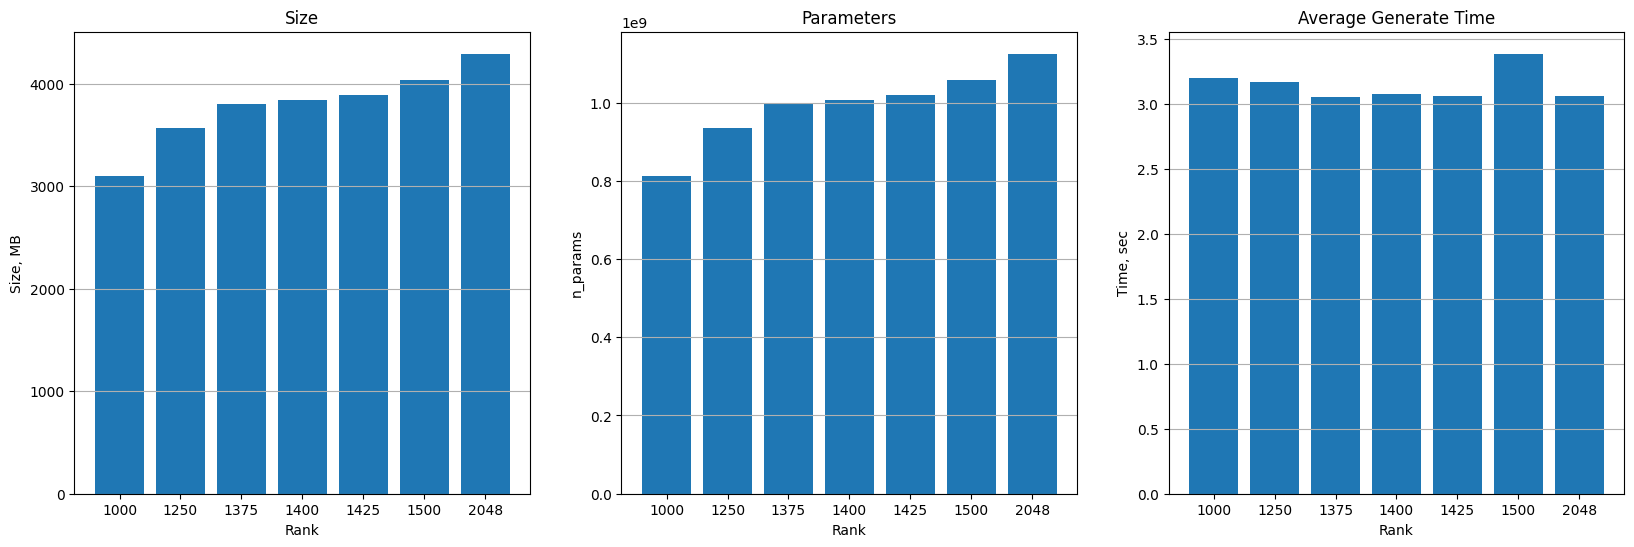

In [19]:
fig, ax = plt.subplots(1, 3)

ax[0].bar(ranks_str, sizes_mbytes)
ax[0].set_xlabel('Rank'), ax[0].set_ylabel('Size, MB')
ax[0].set_title('Size'), ax[0].grid(True, axis="y")

ax[1].bar(ranks_str, arr_n_params)
ax[1].set_xlabel('Rank'), ax[1].set_ylabel('n_params')
ax[1].set_title('Parameters'), ax[1].grid(True, axis="y")

ax[2].bar(ranks_str, times)
ax[2].set_xlabel('Rank'), ax[2].set_ylabel('Time, sec')
ax[2].set_title('Average Generate Time'), ax[2].grid(True, axis="y")

fig.set_size_inches(20, 6)
plt.show()

Видно, что чем меньше ранг сжатия, тем меньше памяти занимает модель. При этом выигрыш по времени генерации достигается при рангах $r = 1250,1400,1425$.